In [2]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch
import yaml
from lightning.pytorch import Trainer
from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import os
import tempfile

import timm
import torch
from lightning.pytorch import Trainer

In [4]:
module_path = os.path.abspath(os.path.join('npatel23/Crop Classification Project/Crop_Segmentation_Project/src'))
sys.path.insert(0, module_path)

In [5]:
from src.custom_dataset import CropData
from src.models.unet import Unet
from src.model_compiler import ModelCompiler
from src.custom_loss_functions import *
from src.utils import *

# Crop Classification Project/Model_training/src/custom_dataset.py

In [6]:
yaml_config_path = "/home/npatel23/gokhale_user/Crop Classification Project/Crop_Segmentation_Project/config/default_config.yaml"  # replace this path to your own config file.
num_time_points = 1  # Change this number accordingly if you use a dataset with a different temporal length.

with open(yaml_config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.SafeLoader)

# Perform multiplication and concatenation for each key in global_stats
for key, value in config['global_stats'].items():
    config['global_stats'][key] = value * num_time_points

In [7]:
import pprint
pprint.pprint(config, width=100, compact=True)

{'LR': 0.011,
 'LR_policy': 'PolynomialLR',
 'apply_normalization': False,
 'aug_params': {'rotation_degree': [-180, -90, 90, 180]},
 'checkpoint_interval': 5,
 'class_mapping': {0: 'Unknown',
                   1: 'Corn',
                   2: 'Cotton',
                   3: 'Rice',
                   4: 'Sorghum',
                   5: 'Soybeans',
                   6: 'Sunflower',
                   7: 'Peanuts',
                   8: 'Sweet Corn',
                   9: 'Alfalfa',
                   10: 'Durum Wheat',
                   11: 'Spring Wheat',
                   12: 'Winter Wheat',
                   13: 'Rye',
                   14: 'Oats',
                   15: 'Millet',
                   16: 'Alfalfa',
                   17: 'Sugarcane',
                   18: 'Almonds',
                   19: 'other crops',
                   20: 'non crops'},
 'criterion': {'gamma': 0.9,
               'ignore_index': 0,
               'name': 'TverskyFocalLoss',
               '

In [8]:
train_dataset = CropData(src_dir=config["src_dir"],
                         usage="train",
                         dataset_name=config["train_dataset_name"],
                         csv_path=config["train_csv_path"],
                         apply_normalization=config["apply_normalization"],
                         normal_strategy=config["normal_strategy"],
                         stat_procedure=config["stat_procedure"],
                         global_stats=config["global_stats"],
                         trans=config["transformations"], 
                         **config["aug_params"])

100%|██████████| 999/999 [00:09<00:00, 107.19it/s]


------ train dataset with 999 patches created ------


In [9]:
train_loader = DataLoader(train_dataset,
                          batch_size=config["train_BatchSize"], 
                          shuffle=True, num_workers=96)

/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
def plot_channels(image_tensor):
    """Plots each channel of a multi-channel image tensor."""
    num_channels = image_tensor.shape[0]
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15, 8))  # Adjust the layout based on the number of channels
    axes = axes.flatten()

    for i in range(num_channels):
        ax = axes[i]
        channel_data = image_tensor[i].numpy()
        
        # Normalize the data for better visibility
        channel_data = (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data))
        
        im = ax.imshow(channel_data, cmap='gray')
        ax.axis('off')  # Hide axes ticks
        ax.set_title(f'Channel {i+1}')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.colorbar(im, ax=axes.tolist(), orientation='horizontal', pad=0.01)
    plt.show()

In [10]:
def imshow(channel_data):
    """Helper function to unnormalize and display an image"""
    channel_data = (channel_data - np.min(channel_data)) / (np.max(channel_data) - np.min(channel_data))     # unnormalize if normalization is applied in your transform
    npimg = channel_data.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor image
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Choose a random index
idx = torch.randint(len(images), size=(1,)).item()

# Display the image
imshow(images[idx])

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


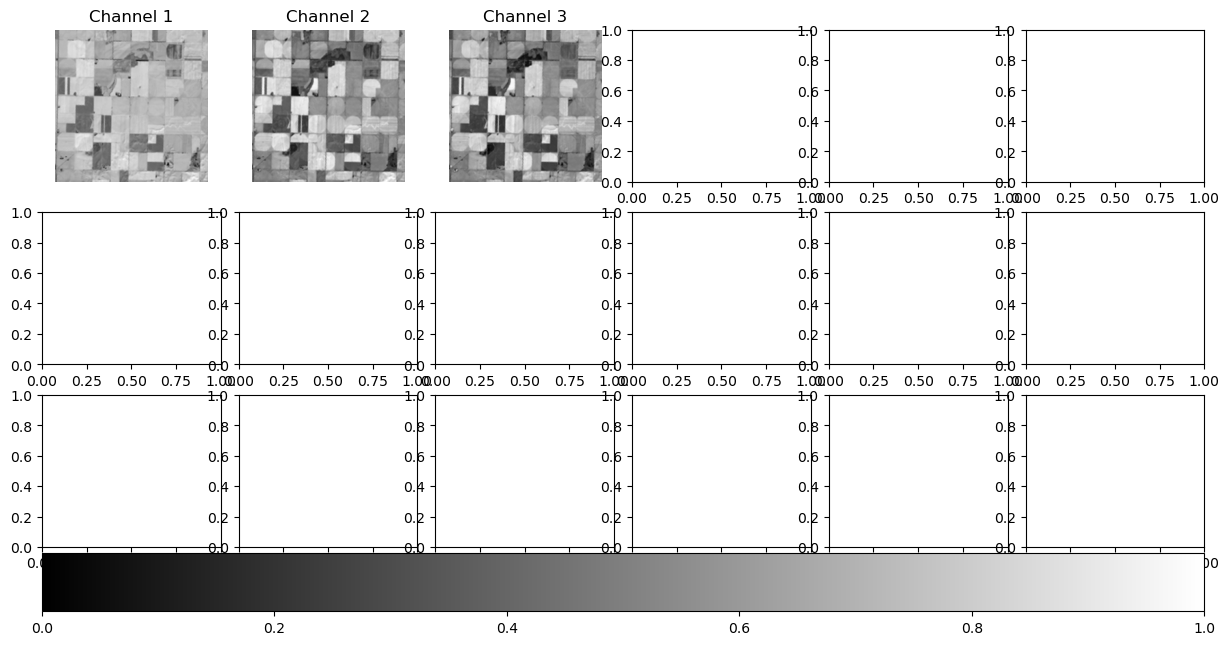

In [45]:
plot_channels(images[idx])

In [12]:
imshow(images[idx])

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


In [13]:
def show_random_patches(dataset, sample_num, rgb_bands=(3, 2, 1)):

    """
    Plots a user-defined number of image chips and the corresponding labels.
    """

    if not (isinstance(rgb_bands, (tuple, list)) and len(rgb_bands) == 3 and 
            all(isinstance(band, numbers.Number) for band in rgb_bands) and
            1 <= sample_num <= len(dataset)):
        raise ValueError("'sample_num' or 'rgb_bands' are not properly defined")
    
    # Sample indices for visualization
    sample_indices = random.sample(range(len(dataset)), sample_num)
    
    fig, axs = plt.subplots(nrows=sample_num, ncols=2, figsize=(16, sample_num * 16 / 2), squeeze=False)
    
    for i, idx in enumerate(sample_indices):
        img, lbl = dataset[idx]
        r, g, b = (img[band,:,:].cpu().view(1, *lbl.shape) for band in rgb_bands)
    
        axs[i, 0].set_title(f'Image Patch #{idx}')
        axs[i, 0].imshow(torch.cat([r, g, b], 0).permute(1, 2, 0))
        axs[i, 1].set_title(f'Label Patch #{idx}')
        axs[i, 1].imshow(lbl)
    
    plt.show()

IndexError: index 2 is out of bounds for dimension 0 with size 1

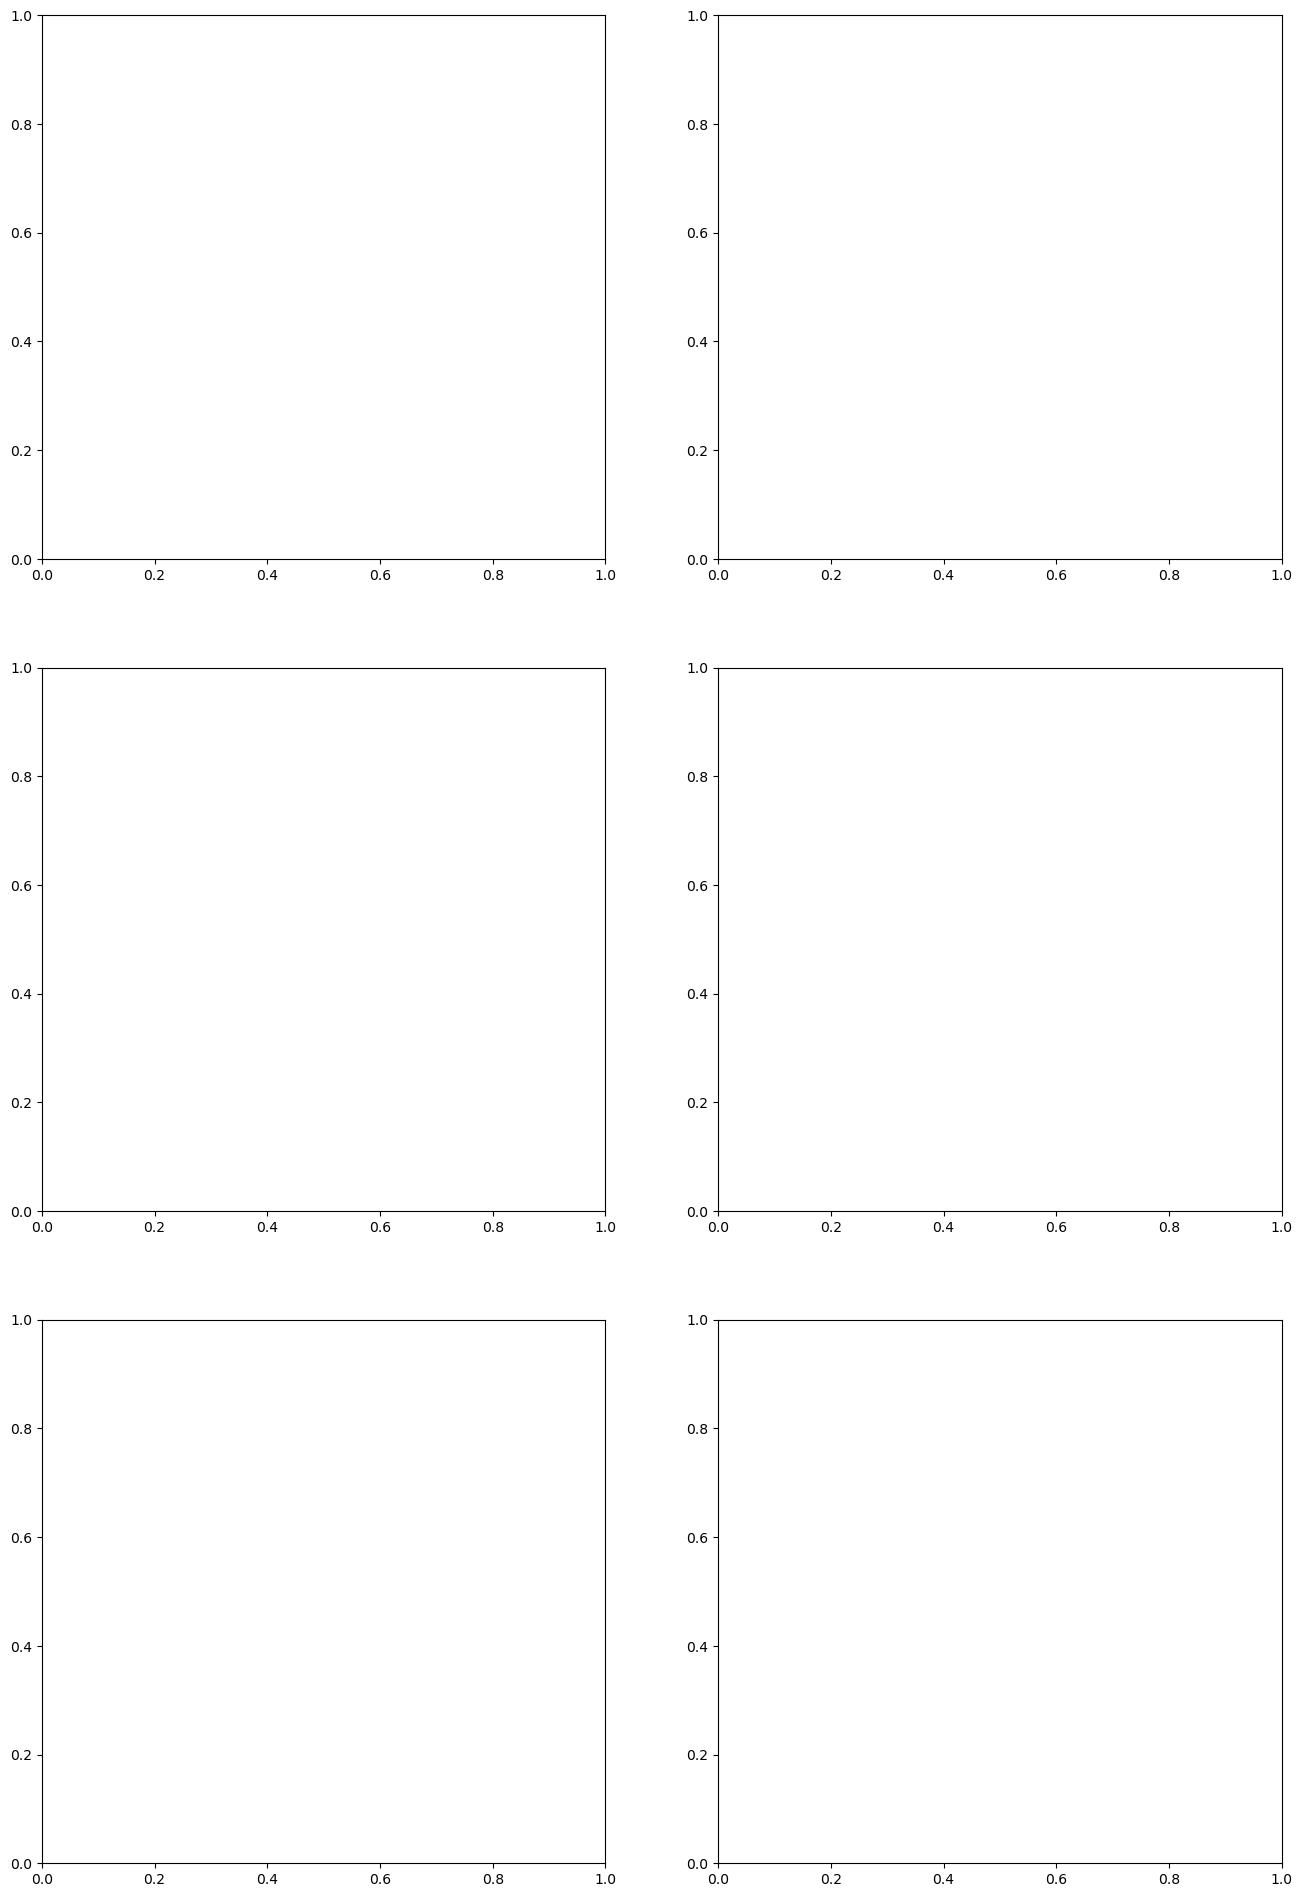

In [14]:
show_random_patches(train_dataset, sample_num=3, rgb_bands=(2, 1, 0))

In [ ]:
for i, l in train_loader:
    print(i.shape)
    print(l)

In [29]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Choose a random index
idx = torch.randint(len(images), size=(1,)).item()

In [31]:
print(np.unique(labels[idx]))

[1 2 3 4]


In [32]:
labels[idx]

tensor([[4, 4, 1,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [1, 1, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 1, 1, 1],
        [4, 4, 4,  ..., 1, 1, 1],
        [4, 4, 4,  ..., 1, 1, 1]])

In [13]:
val_dataset = CropData(src_dir=config["src_dir"],
                       usage="validation",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["val_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

100%|██████████| 1000/1000 [00:08<00:00, 115.12it/s]

------ validation dataset with 1000 patches created ------


In [14]:
val_loader = DataLoader(val_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False, num_workers=96)

/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
import torch
from torchvision.models import resnet18
# from torchvision.models import ResNet18_Weights
from torchgeo.models import ResNet18_Weights
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18

In [14]:
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import timm

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
# Define the modified ResNet for segmentation
## Original ResNet Segementation and commnect model with CE loss class weight

class ResNetSegmentation(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        base_model = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        # self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # print(x.shape)
        # x = self.upsample(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        print(inputs.shape)
        print(labels.shape)
        outputs = self(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        preds = torch.argmax(outputs, dim=1)
        return preds, labels


# class ResNetSegmentation(pl.LightningModule):
#     def __init__(self, num_classes, class_weights=None):
#         super().__init__()
#         base_model = models.resnet18(pretrained=True)
#         self.encoder = nn.Sequential(*list(base_model.children())[:-2])
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, num_classes, kernel_size=1)
#         )
#         self.class_weights = class_weights if class_weights is not None else torch.ones(num_classes)

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

#     def training_step(self, batch, batch_idx):
#         inputs, labels = batch
#         outputs = self(inputs)
#         class_weights_tensor = torch.tensor(self.class_weights, device=self.device, dtype=torch.float32)
#         loss = torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights_tensor)
#         self.log('train_loss', loss)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         inputs, labels = batch
#         outputs = self(inputs)
#         class_weights_tensor = torch.tensor(self.class_weights, device=self.device, dtype=torch.float32)
#         loss = torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights_tensor)
#         self.log('val_loss', loss)
#         return loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.001)

#     def test_step(self, batch, batch_idx):
#         inputs, labels = batch
#         outputs = self(inputs)
#         preds = torch.argmax(outputs, dim=1)
#         return preds, labels

In [24]:
from torchsummary import summary
import torch
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSegmentation(num_classes=4)
summary(model, (1, 224, 224))

NameError: name 'ResNetSegmentation' is not defined

In [17]:
def test_model(model, test_loader):
    predictions, targets = [], []
    for batch in test_loader:
        preds, labels = model.test_step(batch, None)
        predictions.append(preds)
        targets.append(labels)
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    return predictions, targets

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":

    # raw_class_weights = [
    #     1.0, 0.00011497, 0.00009562, 0.00002992, 0.00108596, 0.16593777, 
    #     0.00031582, 0.0, 0.01207342, 0.00043280, 0.00099954, 
    #     0.00243484, 0.00005562, 0.00236051, 0.00044835, 0.73668725, 
    #     0.00002694, 0.07687043, 0.00001686, 0.00000813, 0.00000525
    # ]
    # class_weights = torch.tensor(raw_class_weights[:], dtype=torch.float32)  # Exclude class 0 weight
    # model = ResNetSegmentation(num_classes=21, class_weights=class_weights)

    model = ResNetSegmentation(num_classes=3)
 
    # model = ResNetSegmentation(num_classes=21)
    # train_loader, val_loader = setup_data()
    trainer = pl.Trainer(
        accelerator='cpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=10,
        default_root_dir=os.path.join(os.getcwd(), 'checkpoints')
    )
    trainer.fit(model, train_loader, val_loader)

    # Plotting training loss and validation loss
    plt.plot(trainer.callback_metrics['train_loss'], label='Train Loss')
    plt.plot(trainer.callback_metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:176: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 11.2 M
1 | decoder | Sequential | 721 K 
---------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.593    Total estimated model params size (MB)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [19]:
import os
import pandas as pd
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [31]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, folder_path, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file containing file names and labels.
            folder_path (str): Path to the folder containing all files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Fetch file name and label
        file_name = self.data.iloc[idx, 0]  # Assuming first column is file_name
        image_name = file_name + '_false_color.tif'
        label_name = file_name + '.mask.tif'
        

        # Load image using rasterio
        img_path = os.path.join(self.folder_path, image_name)
        lab_path = os.path.join(self.folder_path, label_name)
        print(img_path)
        print(lab_path)
        with rasterio.open(imga_path) as src:
            image = src.read([1, 2, 3])  # Read the first three channels (RGB)
            image = image.transpose((1, 2, 0))  # Convert to HWC format

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

In [32]:
train_csv_path = '/home/npatel23/gokhale_user/Crop Classification Project/Crop_Segmentation_Project/chip_summary_2023_training.csv'
test_csv_path = '/home/npatel23/gokhale_user/Crop Classification Project/Crop_Segmentation_Project/chip_summary_2022_testing.csv'
folder_path = '/home/npatel23/gokhale_user/Crop Classification Project/Crop Classification Project/HLS_CDL_Data/sample_chips'

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()          # Convert images to PyTorch tensors
])

# Create datasets
train_dataset = CustomDataset(csv_file=train_csv_path, folder_path=folder_path, transform=transform)
val_dataset = CustomDataset(csv_file=test_csv_path, folder_path=folder_path, transform=transform)

In [10]:
img_path = '/home/npatel23/gokhale_user/Crop Classification Project/Crop Classification Project/HLS_CDL_Data/sample_chips/chip_197_072_2023-07-16_false_color.tif'
with rasterio.open(img_path) as src:
        image = src.read()
        # image = image.transpose((1, 2, 0))
image = image.transpose((0, 1, 2))
print(f"Image Max Value: {image.max()}, Min Value: {image.min()}")
if image.max() > 1.0:
    image = image / 255.0

print(f"Image Shape (HWC): {image.shape}")
print(f"Image Max Value: {image.max()}, Min Value: {image.min()}")

Image Max Value: 5483.0, Min Value: 130.0
Image Shape (HWC): (3, 224, 224)
Image Max Value: 21.50196075439453, Min Value: 0.5098039507865906


In [34]:
print(train_dataset)

/home/npatel23/gokhale_user/Crop Classification Project/Crop Classification Project/HLS_CDL_Data/sample_chips/chip_197_072_2023-07-16_false_color.tif
/home/npatel23/gokhale_user/Crop Classification Project/Crop Classification Project/HLS_CDL_Data/sample_chips/chip_197_072_2023-07-16.mask.tif


NameError: name 'imga_path' is not defined

In [10]:
import torch
import torch.nn as nn

# Define the modified UNet2D model
class UNet2D(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet2D, self).__init__()
        feats = 16
        self.en3 = conv_block(in_channels, feats * 4, feats * 4)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.en4 = conv_block(feats * 4, feats * 8, feats * 8)
        self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.center_in = center_in(feats * 8, feats * 16)
        self.center_out = center_out(feats * 16, feats * 8)
        self.dc4 = conv_block(feats * 16, feats * 8, feats * 8)
        self.trans3 = up_conv_block(feats * 8, feats * 4)
        self.dc3 = conv_block(feats * 8, feats * 4, feats * 2)
        self.final = nn.Conv2d(feats * 2, n_classes, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        en3 = self.en3(x)
        pool_3 = self.pool_3(en3)
        en4 = self.en4(pool_3)
        pool_4 = self.pool_4(en4)
        center_in = self.center_in(pool_4)
        center_out = self.center_out(center_in)
        concat4 = torch.cat([center_out, en4], dim=1)
        dc4 = self.dc4(concat4)
        trans3 = self.trans3(dc4)
        concat3 = torch.cat([trans3, en3], dim=1)
        dc3 = self.dc3(concat3)
        final = self.final(dc3)
        return final

# Supporting block functions
def conv_block(in_dim, middle_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, middle_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(middle_dim),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(middle_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(inplace=True),
    )
    return model

def center_in(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(inplace=True))
    return model

def center_out(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, in_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_dim),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1))
    return model

def up_conv_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        nn.LeakyReLU(inplace=True),
    )
    return model

# Initialize the model
# model = UNet2D(in_channels=3, n_classes=4)

# # Simulate a batch of input images (batch size = 1 for simplicity)
# input_tensor = torch.randn(1, 3, 224, 224)  # (batch_size, channels, height, width)

# # Forward pass through the model
# output = model(input_tensor)
# # Print the shape of the output tensor
# print("Output shape:", output.shape)  # Expected shape: (1, 4, 224, 224), where 4 is the number of classes


In [11]:
from torchsummary import summary
model = UNet2D(in_channels=3, n_classes=5)
summary(model, (1, 224, 224))

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: []

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm

# Assuming the model and loaders are defined:
model = UNet2D(in_channels=1, n_classes=5)
# train_loader and val_loader are already defined and loaded with data.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as necessary

# Training Loop
def train_model(num_epochs, model, train_loader, val_loader, criterion, optimizer, device):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        print(f"Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for i, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        # Validation after each epoch
        if (epoch + 1) % 5 == 0:
            validate_model(model, val_loader, criterion, device)

# Validation Function with Metrics
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
    with torch.no_grad():  # No need to track gradients
        for i, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            # Collect predictions and true labels for metrics
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
            # print(np.unique(all_preds))

            progress_bar.set_postfix(loss=loss.item())

    total_loss = val_running_loss / len(val_loader.dataset)
    print(f"Validation Loss: {total_loss:.4f}")

    # Flatten the predictions and labels
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()

    # Calculate metrics
    num_classes = len(np.unique(all_labels))
    iou_per_class = []

    for cls in range(num_classes):
        intersection = np.logical_and(all_preds == cls, all_labels == cls).sum()
        union = np.logical_or(all_preds == cls, all_labels == cls).sum()
        iou = intersection / union if union != 0 else 0
        iou_per_class.append(iou)

    mean_iou = np.mean(iou_per_class)

    # Confusion matrix and derived metrics
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Print metrics
    print(f"IoU per Class: {iou_per_class}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Call to train the model
num_epochs = 50  # You can adjust the number of epochs
train_model(num_epochs, model, train_loader, val_loader, criterion, optimizer, device)

Epoch 1/50


Training: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s, loss=1.24]

Epoch 1/50, Loss: 1.3081
Epoch 2/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s, loss=1.25]

Epoch 2/50, Loss: 1.2605
Epoch 3/50



Training: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s, loss=1.25]

Epoch 3/50, Loss: 1.2615
Epoch 4/50



Training: 100%|██████████| 50/50 [00:16<00:00,  2.97it/s, loss=1.16]

Epoch 4/50, Loss: 1.2610
Epoch 5/50



Training: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s, loss=1.21]

Epoch 5/50, Loss: 1.2584



Validation: 100%|██████████| 167/167 [00:06<00:00, 24.48it/s, loss=1.29]


Validation Loss: 1.2626
IoU per Class: [0, 0.23238967747126166, 0.0, 0.09347918216841208]
Mean IoU: 0.0815
Confusion Matrix:
[[      0       0       0       0]
 [      0 4783227       0  927575]
 [      0  658215       0  422433]
 [      0  846872       0 1140594]]
Accuracy: 0.6748
Precision: 0.3212
Recall: 0.3063
F1 Score: 0.2669
Epoch 6/50


/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s, loss=1.21]

Epoch 6/50, Loss: 1.2538
Epoch 7/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s, loss=1.26]

Epoch 7/50, Loss: 1.2515
Epoch 8/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s, loss=1.23]

Epoch 8/50, Loss: 1.2432
Epoch 9/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s, loss=1.2] 

Epoch 9/50, Loss: 1.2427
Epoch 10/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s, loss=1.26]

Epoch 10/50, Loss: 1.2440



Validation: 100%|██████████| 167/167 [00:07<00:00, 22.27it/s, loss=1.3] 


Validation Loss: 1.2407
IoU per Class: [0, 0.31542181815125186, 0.0, 0.18952033381619612]
Mean IoU: 0.1262
Confusion Matrix:
[[      0       0       0       0]
 [      0 7842632       0 2214644]
 [      0 1387913       0 1003020]
 [      0 1955714       0 2921719]]
Accuracy: 0.6213
Precision: 0.3147
Recall: 0.3420
F1 Score: 0.3227
Epoch 11/50


/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s, loss=1.34]

Epoch 11/50, Loss: 1.2398
Epoch 12/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s, loss=1.18]

Epoch 12/50, Loss: 1.2351
Epoch 13/50



Training: 100%|██████████| 50/50 [00:18<00:00,  2.75it/s, loss=1.21]

Epoch 13/50, Loss: 1.2331
Epoch 14/50



Training: 100%|██████████| 50/50 [00:18<00:00,  2.75it/s, loss=1.26]

Epoch 14/50, Loss: 1.2362
Epoch 15/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s, loss=1.26]

Epoch 15/50, Loss: 1.2273



Validation: 100%|██████████| 167/167 [00:07<00:00, 21.73it/s, loss=1.3] 


Validation Loss: 1.2822
IoU per Class: [0, 0.22693259999244264, 0.0, 0.017394469998716154]
Mean IoU: 0.0611
Confusion Matrix:
[[      0       0       0       0]
 [      0 4480181       0  119606]
 [      0  553151       0   80215]
 [      0  744254       0  178030]]
Accuracy: 0.7568
Precision: 0.3466
Recall: 0.2983
F1 Score: 0.2342
Epoch 16/50


/home/npatel23/gokhale_ada/users/npatel23/conda_envs/cropclassi/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 96 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s, loss=1.26]

Epoch 16/50, Loss: 1.2290
Epoch 17/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s, loss=1.13]

Epoch 17/50, Loss: 1.2205
Epoch 18/50



Training: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s, loss=1.29]

Epoch 18/50, Loss: 1.2230
Epoch 19/50



Training: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s, loss=1.18]

Epoch 19/50, Loss: 1.2169
Epoch 20/50



Training: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s, loss=1.32]

Epoch 20/50, Loss: 1.2142



Validation: 100%|██████████| 167/167 [00:07<00:00, 21.54it/s, loss=1.32]


Validation Loss: 1.3256


In [ ]:
device = torch.device("cuda")
model.to(device)

In [18]:
validate_model(model, val_loader, criterion, device)

Validation: 100%|██████████| 167/167 [00:08<00:00, 20.17it/s, loss=1.21]


Validation Loss: 1.3060
IoU per Class: [0, 0.1458839006733306, 0.0, 0.20420246621918078]
Mean IoU: 0.0875
Confusion Matrix:
[[      0       0       0       0]
 [      0 3196517       0 5044714]
 [      0  704053       0 1813019]
 [      0 1452945       0 4491227]]
Accuracy: 0.4603
Precision: 0.2598
Recall: 0.2962
F1 Score: 0.2596
